# Tutorial 08: Building Complex Flows with LangGraph

In this tutorial, we'll explore how to create more complex and sophisticated workflows using LangGraph. We'll build on the concepts introduced in Tutorial 07 and dive into multi-step processes, conditional logic, and error handling.

## Setup

First, let's import the necessary libraries and set up our environment:

In [8]:
import os
from typing import Dict, TypedDict, List, Annotated
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.schema import BaseMessage
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

# Initialize the Groq LLM
llm = ChatGroq(
        model_name="qwen-2.5-32b",
        temperature=0.1,
        model_kwargs={"top_p": 0.5, "seed": 1337}
    )

# Define our state structure
class State(TypedDict):
    messages: Annotated[List[BaseMessage], "append_only"]
    current_step: str
    task_list: List[str]
    error_count: int

## 1. Designing multi-step workflows

Let's create a multi-step task planning and execution workflow. This workflow will:
1. Greet the user and ask for a task
2. Break down the task into subtasks
3. Execute each subtask
4. Provide a summary of the completed task

In [15]:
# Define our graph
workflow = StateGraph(State)

# Define our nodes
def greet_and_ask(state: State) -> State:
    return {
        "messages": [{"role": "assistant", "content": "Hello! What task can I help you with today?"}],
        "current_step": "break_down_task"
    }

def break_down_task(state: State) -> State:
    task = state["messages"][-1]["content"]
    prompt = ChatPromptTemplate.from_template(
        "Break down the following task into 3-5 subtasks: {task}"
    )
    response = llm(prompt.format_messages(task=task))
    subtasks = response.content.split("\n")
    return {
        "task_list": subtasks,
        "messages": [{"role": "assistant", "content": f"I've broken down your task into the following subtasks:\n{response.content}"}],
        "current_step": "execute_subtask"
    }

def execute_subtask(state: State) -> State:
    if not state["task_list"]:
        return {"current_step": "summarize"}
    
    current_task = state["task_list"][0]
    remaining_tasks = state["task_list"][1:]
    
    prompt = ChatPromptTemplate.from_template(
        "Execute the following subtask and provide a brief result: {task}"
    )
    response = llm(prompt.format_messages(task=current_task))
    
    next_step = "execute_subtask" if remaining_tasks else "summarize"
    
    return {
        "messages": [{"role": "assistant", "content": f"Completed subtask: {current_task}\nResult: {response.content}"}],
        "task_list": remaining_tasks,
        "current_step": next_step
    }

## 2. Handling state and transitions

In the above workflow, we're using the `current_step` key in our state to manage transitions between nodes. This allows us to create more complex flows with multiple possible paths.

## 3. Implementing conditional logic in flows

Now, let's add some conditional logic to our workflow. We'll implement a check to see if the user wants to add more tasks after the initial task is completed.

In [16]:
def summarize(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Summarize the completed task and its results based on the following conversation: {conversation}"
    )
    conversation = "\n".join([f"{m['role']}: {m['content']}" for m in state["messages"]])
    response = llm(prompt.format_messages(conversation=conversation))
    
    return {
        "messages": [{"role": "assistant", "content": f"Task Summary:\n{response.content}"}],
        "current_step": "check_for_more_tasks"
    }

def check_for_more_tasks(state: State) -> State:
    return {
        "messages": [{"role": "assistant", "content": "Would you like to add another task? (yes/no)"}],
        "current_step": "get_user_response"
    }

def get_user_response(state: State) -> State:
    response = state["messages"][-1]["content"].lower()
    
    if response == "yes":
        return {"current_step": "greet_and_ask"}
    elif response == "no":
        return {"current_step": "end"}
    else:
        return {
            "messages": [{"role": "assistant", "content": "I didn't understand that. Please answer 'yes' or 'no'."}],
            "current_step": "get_user_response"
        }

def handle_error(state: State) -> State:
    error_count = state["error_count"] + 1
    
    if error_count > 3:
        return {
            "messages": [{"role": "assistant", "content": "I'm having trouble understanding. Let's start over."}],
            "error_count": 0,
            "current_step": "greet_and_ask"
        }
    else:
        return {
            "messages": [{"role": "assistant", "content": "I'm sorry, I didn't understand that. Could you please rephrase?"}],
            "error_count": error_count
        }

## 4. Error handling and fallback strategies

Lastly, let's implement some basic error handling in our workflow. We'll add a counter for errors and implement a fallback strategy if too many errors occur.

In [17]:
# Add nodes to the graph
workflow.add_node("greet_and_ask", greet_and_ask)
workflow.add_node("break_down_task", break_down_task)
workflow.add_node("execute_subtask", execute_subtask)
workflow.add_node("summarize", summarize)
workflow.add_node("check_for_more_tasks", check_for_more_tasks)
workflow.add_node("get_user_response", get_user_response)
workflow.add_node("handle_error", handle_error)

# Define edges
workflow.set_entry_point("greet_and_ask")
workflow.add_edge("greet_and_ask", "break_down_task")
workflow.add_edge("break_down_task", "execute_subtask")
workflow.add_edge("execute_subtask", "execute_subtask")
workflow.add_edge("execute_subtask", "summarize")
workflow.add_edge("summarize", "check_for_more_tasks")
workflow.add_edge("check_for_more_tasks", "get_user_response")
workflow.add_edge("get_user_response", "greet_and_ask")
workflow.add_edge("get_user_response", END)
workflow.add_edge("get_user_response", "get_user_response")

# Add error handling edges
for node in ["break_down_task", "execute_subtask", "summarize", "get_user_response"]:
    workflow.add_edge(node, "handle_error")
workflow.add_edge("handle_error", "greet_and_ask")
for node in ["break_down_task", "execute_subtask", "summarize", "get_user_response"]:
    workflow.add_edge("handle_error", node)

# Compile the graph
app = workflow.compile()

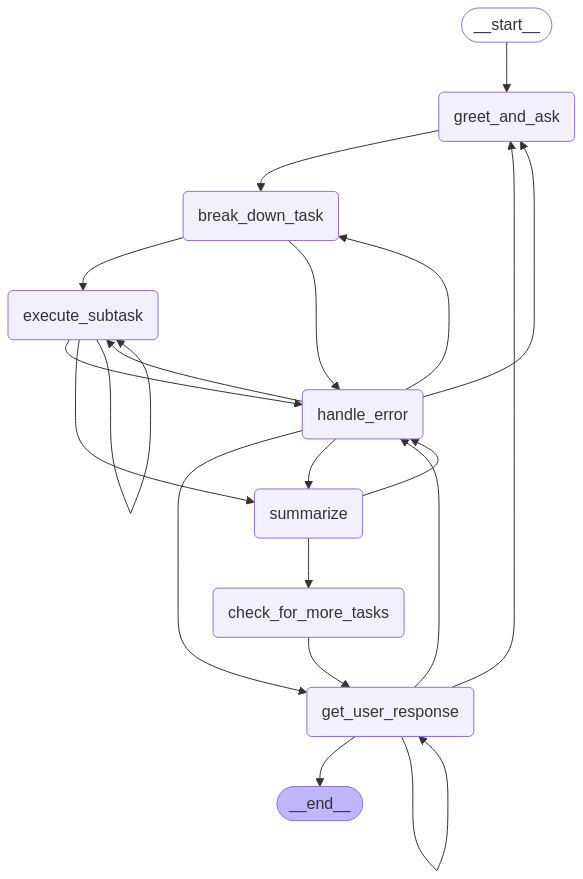

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Now, let's test our complex LangGraph flow:

In [19]:
# Initial state
initial_state = {"messages": [], "current_step": "", "task_list": [], "error_count": 0}

# Run the workflow
for event in app.stream(initial_state):
    for output in event.values():
        if "messages" in output and output["messages"]:
            last_message = output["messages"][-1]
            if last_message["role"] == "assistant":
                print(f"Assistant: {last_message['content']}")
            elif last_message["role"] == "human":
                print(f"Human: {last_message['content']}")
    
        if output.get("current_step") in ["break_down_task", "get_user_response"]:
            user_input = input("Your response: ")
            output["messages"].append({"role": "human", "content": user_input})

print("Workflow completed.")

Assistant: Hello! What task can I help you with today?
Assistant: I've broken down your task into the following subtasks:
Breaking down the task "Tell me about AI" into subtasks can help organize the information in a structured way. Here are three subtasks that can be used to cover the topic comprehensively:

1. **Define AI and Its Historical Context**: Start by defining what artificial intelligence (AI) is, including its basic principles and how it has evolved over time. Discuss key milestones in AI history, such as the Dartmouth Conference in 1956, the development of expert systems in the 1980s, and the rise of machine learning and deep learning in the 21st century.

2. **Explore Different Types of AI**: Dive into the different types of AI, including narrow or weak AI, which is designed to perform a narrow task (like facial recognition or internet searches), and general or strong AI, which would have the ability to understand, learn, and apply knowledge across a wide range of tasks, 

InvalidUpdateError: At key 'messages': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

## Conclusion

In this tutorial, we've explored how to build complex flows with LangGraph, including:
